In [70]:
import torch
from torch import nn, optim
from torch.nn import functional as F
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset
from torch.autograd import Variable
from torch.optim import lr_scheduler

from sklearn.metrics import r2_score
from sklearn import preprocessing
#import scipy.io as sio

from models import VAE,AEBase,Predictor
from models import DNN
import numpy as np
import pandas as pd
import models
import utils as ut
import copy

from scipy import stats


In [71]:
from scipy.stats import pearsonr

# Parameters

In [72]:
# Define parameters
epochs = 500 #200,500,1000  
#dim_au_in = 20049
dim_au_out = 512 #8, 16, 32, 64, 128, 256,512
dim_dnn_in = dim_au_out
dim_dnn_out=1
select_drug = 'Entinostat'
na = -1

# Import data

In [73]:
data_r=pd.read_csv('data/GDSC2_expression.csv',index_col=0)
label_r=pd.read_csv('data/GDSC2_label_9drugs.csv',index_col=0)

In [74]:
label_r=label_r.fillna(na)

In [75]:
hvg,adata = ut.highly_variable_genes(data_r)

In [76]:
selected_idx = label_r.loc[:,select_drug]!=na

In [77]:
data_r.columns = adata.var_names

# Your is gene-cell, mine is cell-gene

In [78]:
#data = data_r.loc[selected_idx,:]
data = data_r.loc[selected_idx,hvg]

In [79]:
label = label_r.loc[selected_idx,select_drug]
#sscaler = preprocessing.StandardScaler(with_mean=True, with_std=True)
mmscaler = preprocessing.MinMaxScaler()
lbscaler = preprocessing.MinMaxScaler()

data = mmscaler.fit_transform(data)
label = lbscaler.fit_transform(label.values.reshape(-1,1))
#label = label.values.reshape(-1,1)

In [80]:
print(np.std(data))
print(np.mean(data))

0.25175280608528416
0.24212160701395455


In [81]:
data.mean(axis=0)


array([0.47806461, 0.07789249, 0.20505775, ..., 0.12038875, 0.05430149,
       0.40485924])

In [82]:
print(data.max())
print(data.min())

1.0000000000000004
0.0


In [83]:
data.shape

(804, 5116)

In [84]:
label_r.shape

(804, 9)

# Split test train

In [85]:
from sklearn.model_selection import train_test_split
X_train_all, X_test, Y_train_all, Y_test = train_test_split(data, label, test_size=0.2, random_state=42)
X_train, X_valid, Y_train, Y_valid = train_test_split(X_train_all, Y_train_all, test_size=0.2, random_state=42)

In [86]:
print(data.shape)
print(label.shape)
print(X_train.shape, Y_train.shape)
print(X_test.shape, Y_test.shape)

(804, 5116)
(804, 1)
(514, 5116) (514, 1)
(161, 5116) (161, 1)


In [87]:
print(X_train.max())
print(X_train.min())

1.0000000000000004
0.0


# AE MODEL

In [88]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# Assuming that we are on a CUDA machine, this should print a CUDA device:
print(device)
torch.cuda.set_device(device)

cuda:0


# Add all data to AE

In [89]:
X_trainTensor = torch.FloatTensor(X_train).to(device)
X_validTensor = torch.FloatTensor(X_valid).to(device)
X_testTensor = torch.FloatTensor(X_test).to(device)
X_allTensor = torch.FloatTensor(data).to(device)
#X_alltrainTensor = torch.FloatTensor(X_train_all).to(device)


Y_trainTensor = torch.FloatTensor(Y_train).to(device)
Y_validTensor = torch.FloatTensor(Y_valid).to(device)

# construct TensorDataset
train_dataset = TensorDataset(X_trainTensor, X_trainTensor)
valid_dataset = TensorDataset(X_validTensor, X_validTensor)
test_dataset = TensorDataset(X_testTensor, X_testTensor)
all_dataset = TensorDataset(X_allTensor, X_allTensor)

X_trainDataLoader = DataLoader(dataset=train_dataset, batch_size=200, shuffle=True)
X_validDataLoader = DataLoader(dataset=valid_dataset, batch_size=200, shuffle=True)
X_allDataLoader = DataLoader(dataset=all_dataset, batch_size=200, shuffle=True)

In [90]:
dataloader = X_trainDataLoader

In [91]:
dataloaders_train = {'train':X_trainDataLoader,'val':X_validDataLoader}

In [92]:
X_trainDataLoader.dataset.tensors[0].shape[0]

514

In [93]:
{x: dataloaders_train[x].dataset.tensors[0].shape[0] for x in ['train', 'val']}

{'train': 514, 'val': 129}

# The model

In [94]:
model = AEBase(input_dim=data.shape[1],latent_dim=512,hidden_dims=[2048,1024])

In [95]:
print(model)

AEBase(
  (encoder): Sequential(
    (0): Sequential(
      (0): Linear(in_features=5116, out_features=2048, bias=True)
      (1): BatchNorm1d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): Dropout(p=0.3, inplace=False)
    )
    (1): Sequential(
      (0): Linear(in_features=2048, out_features=1024, bias=True)
      (1): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): Dropout(p=0.3, inplace=False)
    )
  )
  (bottleneck): Linear(in_features=1024, out_features=512, bias=True)
  (decoder_input): Linear(in_features=512, out_features=1024, bias=True)
  (decoder): Sequential(
    (0): Sequential(
      (0): Linear(in_features=1024, out_features=2048, bias=True)
      (1): BatchNorm1d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): Dropout(p=0.3, inplace=False)
    )
  )
  (final_layer): Sequential(
    (0): Linear(in_features=2048, out_features=5116, bias=True)
    (1): Sigmoid(

In [96]:
#model = VAE(dim_au_in=data_r.shape[1],dim_au_out=128)
if torch.cuda.is_available():
    model.cuda()
model.to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-2)
loss_function = nn.MSELoss()

# Decay LR by a factor of 0.1 every 7 epochs
#exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
exp_lr_scheduler = lr_scheduler.ReduceLROnPlateau(optimizer)

In [97]:
def train_ae_model(net,data_loaders={},optimizer=None,loss_function=None,n_epochs=100,scheduler=None,load=None):
    
    if(load!=None):
        net.load_state_dict(torch.load(load))           
    
        return net, 0
    
    dataset_sizes = {x: data_loaders[x].dataset.tensors[0].shape[0] for x in ['train', 'val']}
    loss_train = {}
    
    best_model_wts = copy.deepcopy(net.state_dict())
    best_loss = np.inf

    for epoch in range(n_epochs):
        print('Epoch {}/{}'.format(epoch, n_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                #optimizer = scheduler(optimizer, epoch)
                net.train()  # Set model to training mode
            else:
                net.eval()  # Set model to evaluate mode

            running_loss = 0.0

            # Iterate over data.
            # for data in data_loaders[phase]:
            for batchidx, (x, _) in enumerate(data_loaders[phase]):

                x.requires_grad_(True)
                # encode and decode 
                output = net(x)
                # compute loss
                loss = loss_function(output, x)      

                # zero the parameter (weight) gradients
                optimizer.zero_grad()

                # backward + optimize only if in training phase
                if phase == 'train':
                    loss.backward()
                    # update the weights
                    optimizer.step()

                # print loss statistics
                running_loss += loss.item()
            
            # Schedular
#             if phase == 'train':
#                 scheduler.step()
                
            epoch_loss = running_loss / dataset_sizes[phase]
            
            if phase == 'train':
                scheduler.step(epoch_loss)
                
            last_lr = scheduler.optimizer.param_groups[0]['lr']
            loss_train[epoch,phase] = epoch_loss
            print('{} Loss: {:.8f}. Learning rate = {}'.format(phase, epoch_loss,last_lr))
            
            if phase == 'val' and epoch_loss < best_loss:
                best_loss = epoch_loss
                best_model_wts = copy.deepcopy(net.state_dict())
    
    # Select best model wts
    torch.save(best_model_wts, 'saved/models/GDSCnew_ae.pkl')
    net.load_state_dict(best_model_wts)           
    
    return net, loss_train

In [98]:
# model,loss_report = train_ae_model(net=model,data_loaders=dataloaders_train,
#                              optimizer=optimizer,loss_function=loss_function,
#                             n_epochs=epochs,scheduler=exp_lr_scheduler)

# If not trained use above
model,loss_report = train_ae_model(net=model,load='saved/models/ae.pkl')

In [99]:
loss_report

0

In [100]:
# # Old code for autoencoders
# for epoch in range(epochs):
#     # 不需要label，所以用一个占位符"_"代替
#     for batchidx, (x, _) in enumerate(X_allDataLoader):
#         x.requires_grad_(True)
#         # encode and decode 
#         output = model(x)
#         # compute loss
#         print(output.shape)
#         loss = loss_function(output, x)      
#         # update
#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()
           
#     loss_train[epoch,0] = loss.item()  
#     print('Epoch: %04d, Training loss=%.8f' %
#           (epoch+1, loss.item()))

In [101]:
# torch.save(model.state_dict(), 'saved/models/ae.pkl')

In [102]:
recon_batch = model(X_trainTensor)

In [103]:
loss_function(recon_batch,X_trainTensor)

tensor(0.0197, device='cuda:0', grad_fn=<MseLossBackward>)

In [104]:
recon_batch

tensor([[0.0319, 0.2075, 0.0521,  ..., 0.0733, 0.0056, 0.4760],
        [0.4225, 0.0076, 0.1139,  ..., 0.1000, 0.0592, 0.5874],
        [0.5225, 0.0131, 0.0775,  ..., 0.1252, 0.1505, 0.5002],
        ...,
        [0.5099, 0.0295, 0.1441,  ..., 0.0815, 0.0305, 0.4053],
        [0.4796, 0.0036, 0.0980,  ..., 0.0849, 0.0257, 0.6387],
        [0.4885, 0.0626, 0.3419,  ..., 0.0338, 0.0173, 0.3377]],
       device='cuda:0', grad_fn=<SigmoidBackward>)

In [105]:
X_trainTensor

tensor([[0.0355, 0.0408, 0.0855,  ..., 0.1037, 0.0339, 0.2028],
        [0.3025, 0.0043, 0.0373,  ..., 0.0246, 0.0239, 0.4718],
        [0.0812, 0.0273, 0.0615,  ..., 0.0671, 0.0704, 0.8705],
        ...,
        [0.7647, 0.0856, 0.0655,  ..., 0.0515, 0.0366, 0.0566],
        [0.3283, 0.0236, 0.0613,  ..., 0.0621, 0.0321, 0.9801],
        [0.5512, 0.0427, 0.7913,  ..., 0.0581, 0.0139, 0.2744]],
       device='cuda:0')

In [106]:
recon_batch.cpu().detach().numpy().min()

1.0406213e-11

In [107]:
train_embeddings = model.encode(X_trainTensor)

In [108]:
feature = train_embeddings.cpu().detach().numpy()

In [109]:
from sklearn import linear_model
clf = linear_model.Lasso(alpha=0.001)
clf.fit(feature, Y_train)

D:\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.005620956420898, tolerance: 0.0019888984970748425
  positive)


Lasso(alpha=0.001)

In [110]:
from sklearn.ensemble import RandomForestRegressor
RFrg = RandomForestRegressor(random_state=0, n_estimators=100)
RFrg.fit(feature, Y_train)

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until


RandomForestRegressor(random_state=0)

In [111]:
testFeature = model.encode(X_testTensor)
lasso = clf.predict(testFeature.detach().cpu().numpy())

In [112]:
rfresult = RFrg.predict(testFeature.detach().cpu().numpy())

In [113]:
from scipy import stats


In [114]:
r2_score(lasso,Y_test)

-0.9398335279390306

In [115]:
stats.pearsonr(lasso,Y_test.flatten())

(0.25514415512310207, 0.0010891455675509072)

In [116]:
r2_score(rfresult,Y_test)

-2.024662668829733

In [117]:
stats.pearsonr(rfresult,Y_test.flatten())

(0.4076669202926192, 7.986707755259404e-08)

In [118]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(feature)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 514 samples in 0.033s...
[t-SNE] Computed neighbors for 514 samples in 0.265s...
[t-SNE] Computed conditional probabilities for sample 514 / 514
[t-SNE] Mean sigma: 35.278369
[t-SNE] KL divergence after 250 iterations with early exaggeration: 59.255310
[t-SNE] KL divergence after 300 iterations: 0.446132


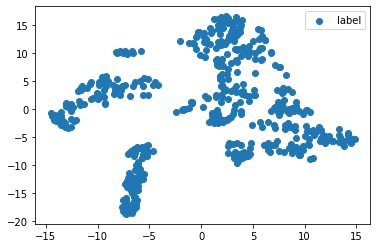

In [119]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.scatter(tsne_results[:, 0], tsne_results[:, 1], label="label")
plt.legend()
plt.savefig("saved/figures/tsne_ae_gdsc.png")

In [120]:
EPOCH = 500

In [121]:
X_trainfeatureTensor = model.encode(X_trainTensor).detach()
#y_trainfeatureTensor = model.encode(X_trainTensor).detach()
X_validfeatureTensor = model.encode(X_validTensor).detach()
#y_validfeatureTensor = model.encode(X_trainTensor).detach()
X_testfeatureTensor = model.encode(X_testTensor).detach()
#y_testfeatureTensor = model.encode(X_trainTensor).detach()

In [122]:
# Load data
# data type conversion

# y_trainTensor = torch.FloatTensor(Y_train).to(device)
# y_validTensor = torch.FloatTensor(Y_valid).to(device)

# construct TensorDataset
trainreducedDataset = TensorDataset(X_trainfeatureTensor, Y_trainTensor)
validreducedDataset = TensorDataset(X_validfeatureTensor, Y_validTensor)

trainDataLoader_p = DataLoader(dataset=trainreducedDataset, batch_size=200, shuffle=True)
validDataLoader_p = DataLoader(dataset=trainreducedDataset, batch_size=200, shuffle=True)

In [123]:
dataloaders_train_p = {'train':trainDataLoader_p,'val':validDataLoader_p}

In [124]:
predictor = Predictor(input_dim=512, output_dim=1,hidden_dims=[256,128,64],drop_out=0.3)

In [125]:
print(predictor)

Predictor(
  (predictor): Sequential(
    (0): Sequential(
      (0): Linear(in_features=512, out_features=256, bias=True)
      (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): Dropout(p=0.3, inplace=False)
    )
    (1): Sequential(
      (0): Linear(in_features=256, out_features=128, bias=True)
      (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): Dropout(p=0.3, inplace=False)
    )
    (2): Sequential(
      (0): Linear(in_features=128, out_features=64, bias=True)
      (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): Dropout(p=0.3, inplace=False)
    )
  )
  (output): Sequential(
    (0): Linear(in_features=64, out_features=1, bias=True)
    (1): Sigmoid()
  )
)


In [126]:
predictor.to(device)
optimizer_p = optim.Adam(predictor.parameters(), lr=1e-2)
loss_function_p = nn.MSELoss()

# Decay LR by a factor of 0.1 every 7 epochs
#exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
lr_scheduler_p = lr_scheduler.ReduceLROnPlateau(optimizer_p)

In [127]:
def train_predictor_model(net,data_loaders,optimizer,loss_function,n_epochs,scheduler,drugName=None):
    
    dataset_sizes = {x: data_loaders[x].dataset.tensors[0].shape[0] for x in ['train', 'val']}
    loss_train = {}
    
    best_model_wts = copy.deepcopy(net.state_dict())
    best_loss = np.inf

    for epoch in range(n_epochs):
        print('Epoch {}/{}'.format(epoch, n_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                #optimizer = scheduler(optimizer, epoch)
                net.train()  # Set model to training mode
            else:
                net.eval()  # Set model to evaluate mode

            running_loss = 0.0

            # Iterate over data.
            # for data in data_loaders[phase]:
            for batchidx, (x, y) in enumerate(data_loaders[phase]):

                x.requires_grad_(True)
                # encode and decode 
                output = net(x)
                # compute loss
                loss = loss_function(output, y)      

                # zero the parameter (weight) gradients
                optimizer.zero_grad()

                # backward + optimize only if in training phase
                if phase == 'train':
                    loss.backward()
                    # update the weights
                    optimizer.step()

                # print loss statistics
                running_loss += loss.item()
            
            # Schedular
#             if phase == 'train':
#                 scheduler.step()
                
            epoch_loss = running_loss / dataset_sizes[phase]
            
            if phase == 'train':
                scheduler.step(epoch_loss)
                
            last_lr = scheduler.optimizer.param_groups[0]['lr']
            loss_train[epoch,phase] = epoch_loss
            print('{} Loss: {:.8f}. Learning rate = {}'.format(phase, epoch_loss,last_lr))
            
            if phase == 'val' and epoch_loss < best_loss:
                best_loss = epoch_loss
                best_model_wts = copy.deepcopy(net.state_dict())
    
    # Select best model wts
    if drugName == None:
        torch.save(best_model_wts, 'saved/models/predictor.pkl')
    else:
        torch.save(best_model_wts, 'saved/models/predictor_'+drugName+'.pkl')
        
    net.load_state_dict(best_model_wts)           
    
    return net, loss_train

In [128]:
predictor,p_loss_report = train_predictor_model(predictor,dataloaders_train_p,optimizer_p,loss_function_p,500,lr_scheduler_p)

Epoch 0/499
----------
train Loss: 0.00064856. Learning rate = 0.01
val Loss: 0.00072791. Learning rate = 0.01
Epoch 1/499
----------
train Loss: 0.00041559. Learning rate = 0.01
val Loss: 0.00062823. Learning rate = 0.01
Epoch 2/499
----------
train Loss: 0.00034080. Learning rate = 0.01
val Loss: 0.00043641. Learning rate = 0.01
Epoch 3/499
----------
train Loss: 0.00031404. Learning rate = 0.01
val Loss: 0.00044038. Learning rate = 0.01
Epoch 4/499
----------
train Loss: 0.00028410. Learning rate = 0.01
val Loss: 0.00039486. Learning rate = 0.01
Epoch 5/499
----------
train Loss: 0.00024974. Learning rate = 0.01
val Loss: 0.00023609. Learning rate = 0.01
Epoch 6/499
----------
train Loss: 0.00023958. Learning rate = 0.01
val Loss: 0.00020857. Learning rate = 0.01
Epoch 7/499
----------
train Loss: 0.00021906. Learning rate = 0.01
val Loss: 0.00026331. Learning rate = 0.01
Epoch 8/499
----------
train Loss: 0.00020071. Learning rate = 0.01
val Loss: 0.00022241. Learning rate = 0.01
E

val Loss: 0.00018158. Learning rate = 0.001
Epoch 73/499
----------
train Loss: 0.00018790. Learning rate = 0.001
val Loss: 0.00018031. Learning rate = 0.001
Epoch 74/499
----------
train Loss: 0.00018090. Learning rate = 0.001
val Loss: 0.00018435. Learning rate = 0.001
Epoch 75/499
----------
train Loss: 0.00017535. Learning rate = 0.001
val Loss: 0.00017787. Learning rate = 0.001
Epoch 76/499
----------
train Loss: 0.00019595. Learning rate = 0.001
val Loss: 0.00018228. Learning rate = 0.001
Epoch 77/499
----------
train Loss: 0.00018085. Learning rate = 0.001
val Loss: 0.00017508. Learning rate = 0.001
Epoch 78/499
----------
train Loss: 0.00017883. Learning rate = 0.001
val Loss: 0.00017752. Learning rate = 0.001
Epoch 79/499
----------
train Loss: 0.00018835. Learning rate = 0.001
val Loss: 0.00017876. Learning rate = 0.001
Epoch 80/499
----------
train Loss: 0.00018686. Learning rate = 0.001
val Loss: 0.00018280. Learning rate = 0.001
Epoch 81/499
----------
train Loss: 0.000184

train Loss: 0.00018097. Learning rate = 1.0000000000000002e-07
val Loss: 0.00017951. Learning rate = 1.0000000000000002e-07
Epoch 141/499
----------
train Loss: 0.00018249. Learning rate = 1.0000000000000004e-08
val Loss: 0.00018282. Learning rate = 1.0000000000000004e-08
Epoch 142/499
----------
train Loss: 0.00017842. Learning rate = 1.0000000000000004e-08
val Loss: 0.00017975. Learning rate = 1.0000000000000004e-08
Epoch 143/499
----------
train Loss: 0.00017792. Learning rate = 1.0000000000000004e-08
val Loss: 0.00018844. Learning rate = 1.0000000000000004e-08
Epoch 144/499
----------
train Loss: 0.00018417. Learning rate = 1.0000000000000004e-08
val Loss: 0.00017903. Learning rate = 1.0000000000000004e-08
Epoch 145/499
----------
train Loss: 0.00019019. Learning rate = 1.0000000000000004e-08
val Loss: 0.00017608. Learning rate = 1.0000000000000004e-08
Epoch 146/499
----------
train Loss: 0.00017952. Learning rate = 1.0000000000000004e-08
val Loss: 0.00018575. Learning rate = 1.000

train Loss: 0.00018404. Learning rate = 1.0000000000000004e-08
val Loss: 0.00018523. Learning rate = 1.0000000000000004e-08
Epoch 196/499
----------
train Loss: 0.00017928. Learning rate = 1.0000000000000004e-08
val Loss: 0.00017584. Learning rate = 1.0000000000000004e-08
Epoch 197/499
----------
train Loss: 0.00017944. Learning rate = 1.0000000000000004e-08
val Loss: 0.00018443. Learning rate = 1.0000000000000004e-08
Epoch 198/499
----------
train Loss: 0.00018316. Learning rate = 1.0000000000000004e-08
val Loss: 0.00017705. Learning rate = 1.0000000000000004e-08
Epoch 199/499
----------
train Loss: 0.00019233. Learning rate = 1.0000000000000004e-08
val Loss: 0.00017632. Learning rate = 1.0000000000000004e-08
Epoch 200/499
----------
train Loss: 0.00019295. Learning rate = 1.0000000000000004e-08
val Loss: 0.00017734. Learning rate = 1.0000000000000004e-08
Epoch 201/499
----------
train Loss: 0.00018556. Learning rate = 1.0000000000000004e-08
val Loss: 0.00018023. Learning rate = 1.000

train Loss: 0.00018435. Learning rate = 1.0000000000000004e-08
val Loss: 0.00017950. Learning rate = 1.0000000000000004e-08
Epoch 253/499
----------
train Loss: 0.00018318. Learning rate = 1.0000000000000004e-08
val Loss: 0.00018195. Learning rate = 1.0000000000000004e-08
Epoch 254/499
----------
train Loss: 0.00018361. Learning rate = 1.0000000000000004e-08
val Loss: 0.00017839. Learning rate = 1.0000000000000004e-08
Epoch 255/499
----------
train Loss: 0.00018937. Learning rate = 1.0000000000000004e-08
val Loss: 0.00017718. Learning rate = 1.0000000000000004e-08
Epoch 256/499
----------
train Loss: 0.00018787. Learning rate = 1.0000000000000004e-08
val Loss: 0.00018178. Learning rate = 1.0000000000000004e-08
Epoch 257/499
----------
train Loss: 0.00017805. Learning rate = 1.0000000000000004e-08
val Loss: 0.00017840. Learning rate = 1.0000000000000004e-08
Epoch 258/499
----------
train Loss: 0.00018285. Learning rate = 1.0000000000000004e-08
val Loss: 0.00018324. Learning rate = 1.000

val Loss: 0.00017917. Learning rate = 1.0000000000000004e-08
Epoch 309/499
----------
train Loss: 0.00018518. Learning rate = 1.0000000000000004e-08
val Loss: 0.00018037. Learning rate = 1.0000000000000004e-08
Epoch 310/499
----------
train Loss: 0.00018839. Learning rate = 1.0000000000000004e-08
val Loss: 0.00018045. Learning rate = 1.0000000000000004e-08
Epoch 311/499
----------
train Loss: 0.00018805. Learning rate = 1.0000000000000004e-08
val Loss: 0.00018134. Learning rate = 1.0000000000000004e-08
Epoch 312/499
----------
train Loss: 0.00018112. Learning rate = 1.0000000000000004e-08
val Loss: 0.00018028. Learning rate = 1.0000000000000004e-08
Epoch 313/499
----------
train Loss: 0.00018436. Learning rate = 1.0000000000000004e-08
val Loss: 0.00018313. Learning rate = 1.0000000000000004e-08
Epoch 314/499
----------
train Loss: 0.00018286. Learning rate = 1.0000000000000004e-08
val Loss: 0.00017682. Learning rate = 1.0000000000000004e-08
Epoch 315/499
----------
train Loss: 0.000184

train Loss: 0.00018514. Learning rate = 1.0000000000000004e-08
val Loss: 0.00017822. Learning rate = 1.0000000000000004e-08
Epoch 367/499
----------
train Loss: 0.00018284. Learning rate = 1.0000000000000004e-08
val Loss: 0.00017414. Learning rate = 1.0000000000000004e-08
Epoch 368/499
----------
train Loss: 0.00019150. Learning rate = 1.0000000000000004e-08
val Loss: 0.00018137. Learning rate = 1.0000000000000004e-08
Epoch 369/499
----------
train Loss: 0.00018119. Learning rate = 1.0000000000000004e-08
val Loss: 0.00018055. Learning rate = 1.0000000000000004e-08
Epoch 370/499
----------
train Loss: 0.00018245. Learning rate = 1.0000000000000004e-08
val Loss: 0.00017942. Learning rate = 1.0000000000000004e-08
Epoch 371/499
----------
train Loss: 0.00019568. Learning rate = 1.0000000000000004e-08
val Loss: 0.00017982. Learning rate = 1.0000000000000004e-08
Epoch 372/499
----------
train Loss: 0.00017768. Learning rate = 1.0000000000000004e-08
val Loss: 0.00017711. Learning rate = 1.000

train Loss: 0.00018210. Learning rate = 1.0000000000000004e-08
val Loss: 0.00017774. Learning rate = 1.0000000000000004e-08
Epoch 422/499
----------
train Loss: 0.00018645. Learning rate = 1.0000000000000004e-08
val Loss: 0.00018210. Learning rate = 1.0000000000000004e-08
Epoch 423/499
----------
train Loss: 0.00018371. Learning rate = 1.0000000000000004e-08
val Loss: 0.00017748. Learning rate = 1.0000000000000004e-08
Epoch 424/499
----------
train Loss: 0.00018615. Learning rate = 1.0000000000000004e-08
val Loss: 0.00017782. Learning rate = 1.0000000000000004e-08
Epoch 425/499
----------
train Loss: 0.00017883. Learning rate = 1.0000000000000004e-08
val Loss: 0.00017768. Learning rate = 1.0000000000000004e-08
Epoch 426/499
----------
train Loss: 0.00018373. Learning rate = 1.0000000000000004e-08
val Loss: 0.00017227. Learning rate = 1.0000000000000004e-08
Epoch 427/499
----------
train Loss: 0.00018671. Learning rate = 1.0000000000000004e-08
val Loss: 0.00018603. Learning rate = 1.000

val Loss: 0.00017681. Learning rate = 1.0000000000000004e-08
Epoch 477/499
----------
train Loss: 0.00019174. Learning rate = 1.0000000000000004e-08
val Loss: 0.00017607. Learning rate = 1.0000000000000004e-08
Epoch 478/499
----------
train Loss: 0.00018408. Learning rate = 1.0000000000000004e-08
val Loss: 0.00018245. Learning rate = 1.0000000000000004e-08
Epoch 479/499
----------
train Loss: 0.00018203. Learning rate = 1.0000000000000004e-08
val Loss: 0.00017529. Learning rate = 1.0000000000000004e-08
Epoch 480/499
----------
train Loss: 0.00018918. Learning rate = 1.0000000000000004e-08
val Loss: 0.00018235. Learning rate = 1.0000000000000004e-08
Epoch 481/499
----------
train Loss: 0.00018158. Learning rate = 1.0000000000000004e-08
val Loss: 0.00017664. Learning rate = 1.0000000000000004e-08
Epoch 482/499
----------
train Loss: 0.00017377. Learning rate = 1.0000000000000004e-08
val Loss: 0.00018206. Learning rate = 1.0000000000000004e-08
Epoch 483/499
----------
train Loss: 0.000181

In [129]:
testpredict = predictor(X_testfeatureTensor)

In [130]:
testpredict

tensor([[0.7271],
        [0.7334],
        [0.7518],
        [0.5546],
        [0.8350],
        [0.7375],
        [0.7880],
        [0.7832],
        [0.7733],
        [0.7683],
        [0.7481],
        [0.6858],
        [0.5092],
        [0.7293],
        [0.7121],
        [0.7804],
        [0.7644],
        [0.5848],
        [0.7783],
        [0.7883],
        [0.7846],
        [0.5951],
        [0.8187],
        [0.7967],
        [0.6972],
        [0.7587],
        [0.7800],
        [0.8015],
        [0.7114],
        [0.7699],
        [0.7743],
        [0.8081],
        [0.7643],
        [0.7096],
        [0.7166],
        [0.7895],
        [0.7214],
        [0.7251],
        [0.6825],
        [0.7755],
        [0.7701],
        [0.7918],
        [0.6994],
        [0.7618],
        [0.6667],
        [0.8013],
        [0.6958],
        [0.5268],
        [0.7480],
        [0.7976],
        [0.7130],
        [0.7858],
        [0.7446],
        [0.7767],
        [0.6936],
        [0

In [131]:
Y_test

array([[0.5952793 ],
       [0.72691923],
       [0.59035843],
       [0.76816175],
       [0.6929002 ],
       [0.69603285],
       [0.68342612],
       [0.78391041],
       [0.59293399],
       [0.87543499],
       [0.80750647],
       [0.61451714],
       [0.5323088 ],
       [0.88994507],
       [0.78527525],
       [0.87986749],
       [0.69924534],
       [0.47866197],
       [0.92279238],
       [0.63332789],
       [0.80962895],
       [0.56549222],
       [0.89390963],
       [0.73942383],
       [0.93660798],
       [1.        ],
       [0.74582097],
       [0.97698887],
       [0.8250415 ],
       [0.92180821],
       [0.76728342],
       [0.8517925 ],
       [0.4489863 ],
       [1.        ],
       [0.85912925],
       [0.74357594],
       [0.65384701],
       [0.38845395],
       [0.66717051],
       [0.95009675],
       [0.0592492 ],
       [0.88980023],
       [0.85993887],
       [0.95232321],
       [0.56730644],
       [0.73117161],
       [0.6480608 ],
       [1.   

In [132]:
from sklearn.metrics import mean_squared_error

In [133]:
dl_result = testpredict.detach().cpu().numpy()

In [134]:
r2_score(dl_result,Y_test)

-3.2679968047582317

In [135]:
pearsonr(dl_result.flatten(),Y_test.flatten())

(0.38936918927543746, 3.308496989097354e-07)

In [136]:
mean_squared_error(testpredict.detach().cpu().numpy(),Y_test)

0.030413489150802935